In [2]:
#Import all necessary libraries and classes
import numpy as np
import pandas as pd
import sklearn.linear_model
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, metrics, base
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import combinations

In [3]:
df = pd.read_csv('shot_logs.csv')
#Change capitals to lower case in column names
df.columns = map(str.lower, df.columns)
df.head()

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [4]:
df.count()


game_id                       128069
matchup                       128069
location                      128069
w                             128069
final_margin                  128069
shot_number                   128069
period                        128069
game_clock                    128069
shot_clock                    122502
dribbles                      128069
touch_time                    128069
shot_dist                     128069
pts_type                      128069
shot_result                   128069
closest_defender              128069
closest_defender_player_id    128069
close_def_dist                128069
fgm                           128069
pts                           128069
player_name                   128069
player_id                     128069
dtype: int64

In [5]:
#Check level of duplication of dataset
#By game_id, player_id, period, game_clock
df['dup'] = df.duplicated(['game_id','player_id','period','game_clock'])
df = df.sort_values(['game_id','player_id','period','game_clock'])
df[['game_id','player_id','period','game_clock','dup']].head(50)
df['dup'].sum()

415

In [6]:

#Locate example duplicates via index value
df.loc[[28670,28671]]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id,dup
28670,21400001,"OCT 28, 2014 - NOP vs. ORL",H,W,17,13,3,3:42,24.0,0,...,2,missed,"Vucevic, Nikola",202696,2.3,0,0,ryan anderson,201583,False
28671,21400001,"OCT 28, 2014 - NOP vs. ORL",H,W,17,14,3,3:42,24.0,0,...,2,made,"Vucevic, Nikola",202696,2.7,1,2,ryan anderson,201583,True


In [7]:
#Level of dataset looks like it should be 1 row per game_id, player_id, period, game_clock
#However, there are duplicates despite this with opposite shot_result values
#For the purposes of the following exercise, I will just drop any duplicates at this level
df = df.drop_duplicates(['game_id','player_id','period','game_clock'])


In [8]:
#To ensure independence of observations, I will continue by looking only at the first shot that each
#player makes per game

df = df.drop_duplicates(['game_id','player_id'],keep='first')
df['dup'] = df.duplicated(['game_id','player_id'])
df['dup'].sum()
df.count()

game_id                       14343
matchup                       14343
location                      14343
w                             14343
final_margin                  14343
shot_number                   14343
period                        14343
game_clock                    14343
shot_clock                    13103
dribbles                      14343
touch_time                    14343
shot_dist                     14343
pts_type                      14343
shot_result                   14343
closest_defender              14343
closest_defender_player_id    14343
close_def_dist                14343
fgm                           14343
pts                           14343
player_name                   14343
player_id                     14343
dup                           14343
dtype: int64

In [9]:
#Check unique values of certain variables
print(df['location'].unique())
print(df['w'].unique())
print(df['shot_result'].unique())
print(df['dribbles'].unique())


['A' 'H']
['L' 'W']
['missed' 'made']
[ 0  1  2 11  4  5 19  3  9 21 15  7 16  6  8 14 25 26 12 13 10 18 17 22
 23 24 20 27 28 30 29 31]


In [10]:
#Count of shot_result
print(df.groupby('shot_result').size())
print(df.groupby('shot_result').size() / df.shape[0])


shot_result
made      6155
missed    8188
dtype: int64
shot_result
made      0.429129
missed    0.570871
dtype: float64


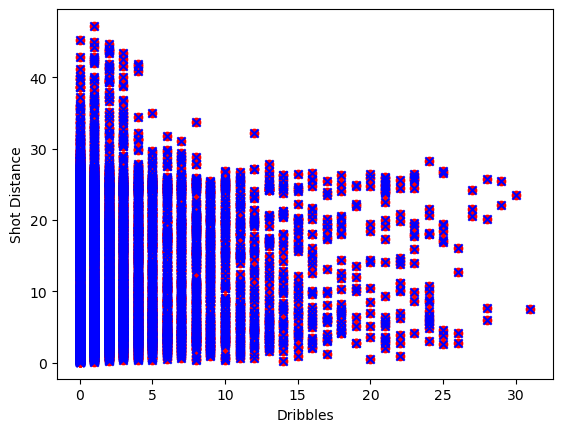

In [11]:
#Scatter plotting dribbles vs shot_dist - splitting by shot_result
plt.scatter(df[['dribbles']['shot_result' == 'missed']],df[['shot_dist']['shot_result' == 'missed']],color='red',marker='o')
plt.scatter(df[['dribbles']['shot_result' == 'made']],df[['shot_dist']['shot_result' == 'made']],color='blue',marker = 'x')
plt.xlabel('Dribbles')
plt.ylabel('Shot Distance')
plt.show()

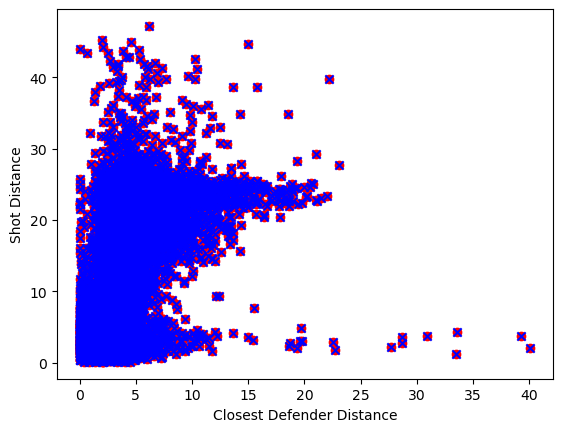

In [12]:
#Scatter plotting close_def_dist vs shot_dist - splitting by shot_result
plt.scatter(df[['close_def_dist']['shot_result' == 'missed']],df[['shot_dist']['shot_result' == 'missed']],color='red',marker='o')
plt.scatter(df[['close_def_dist']['shot_result' == 'made']],df[['shot_dist']['shot_result' == 'made']],color='blue',marker = 'x')
plt.xlabel('Closest Defender Distance')
plt.ylabel('Shot Distance')
plt.show()

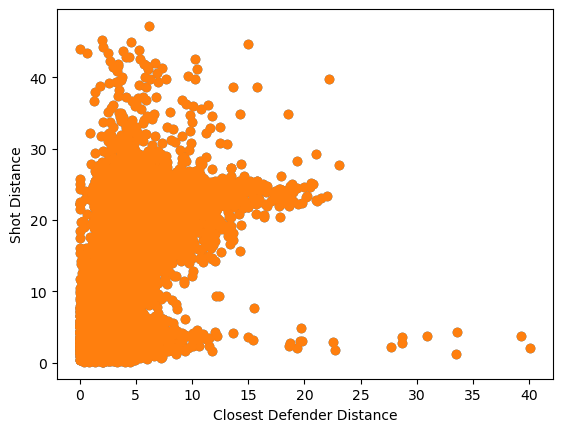

In [13]:
#Scatter plotting close_def_dist vs shot_dist - splitting by location
plt.scatter(df[['close_def_dist']['location' == 'A']],df[['shot_dist']['LOCATION' == 'A']])
plt.scatter(df[['close_def_dist']['location' == 'A']],df[['shot_dist']['LOCATION' == 'H']])
plt.xlabel('Closest Defender Distance')
plt.ylabel('Shot Distance')
plt.show()

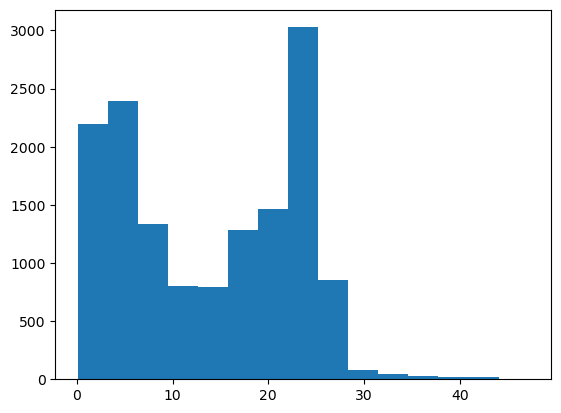

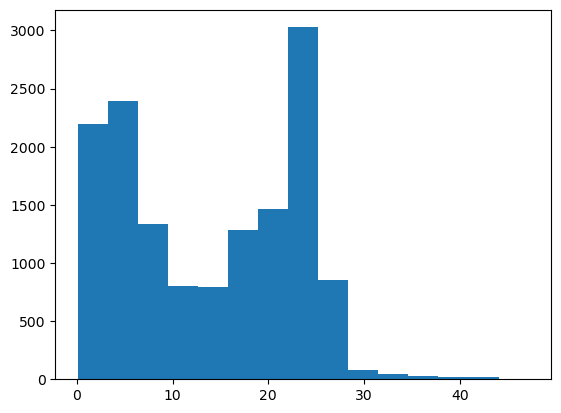

In [14]:
#Histograms
plt.hist(df[['shot_dist']['shot_result' == 'missed']],bins=15)
plt.show()
plt.hist(df[['shot_dist']['shot_result' == 'made']],bins=15)
plt.show()
#The 2 distributions above are identical which suggests that shot_dist will be a weak predictor of
#shot result

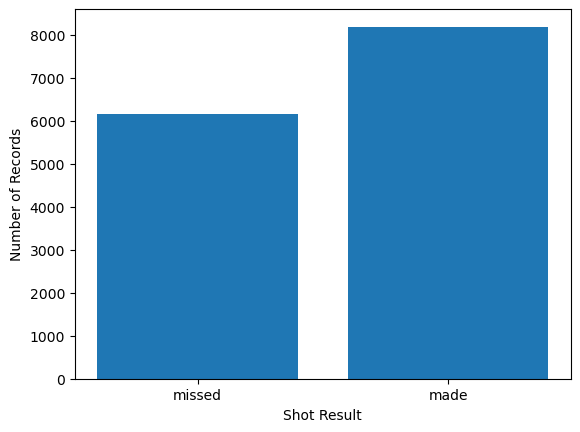

In [15]:
#Plot distribution of shot_result
vals = df['shot_result'].unique()
numVals = np.arange(len(df['shot_result'].unique()))
cntByVal = df.groupby('shot_result').size()
plt.bar(numVals,cntByVal, align='center')
plt.xticks(numVals,vals)
plt.xlabel('Shot Result')
plt.ylabel('Number of Records')
plt.show()

In [16]:
#Iteration 1 - Predict shot result in terms of shot distance

#Data preparation

#check for nulls - No nulls
print(df['shot_dist'].isnull().sum())
print(df['shot_result'].isnull().sum())


0
0


In [17]:
#Create dataset with explanatory variable
X = df['shot_dist']

#Change dependent variable to binary numeric types
df['shot_result_bin'] = np.where(df['shot_result'] == 'made',1,0)
y = df['shot_result_bin']

In [18]:
#Create training and test datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.7, random_state=1)


In [21]:
#Re-shape the output series to have 2 dimensions, as passing 1D arrays to LogisticRegression() is deprecated
print(np.shape(X_train))
print(np.shape(y_train))
X_train = X_train.values.reshape((len(X_train),1))
X_test = X_test.values.reshape((len(X_test),1))


(4302,)
(4302,)


In [22]:
#Logistic Regression model
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [23]:
#Check the values of the model coefficient and intercept
print(lr.intercept_)
print(lr.coef_)


[0.33142429]
[[-0.04803551]]


In [24]:
predTrain = lr.predict(X_train)
predTest = lr.predict(X_test)


In [25]:
#Accuracy score

print('Training Accuracy %.2f' % metrics.accuracy_score(y_train,predTrain))
print('Test Accuracy %.2f' % metrics.accuracy_score(y_test,predTest))
#0.02% less accuracy in the test


Training Accuracy 0.63
Test Accuracy 0.61


In [26]:
#Get arrays for False Postive Rate and True Positive Rate and the corresponding thresholds for the values 
#in these arrays
fpr, tpr, thresholds = metrics.roc_curve(y_train, predTrain)

#Get AUC statistic
auc = metrics.auc(fpr,tpr)


In [27]:
print('False Positive Rate: ',fpr)
print('Frue Positive Rate: ',tpr)
print('Area Under the Curve: ',auc)

False Positive Rate:  [0.     0.2368 1.    ]
Frue Positive Rate:  [0.         0.45394007 1.        ]
Area Under the Curve:  0.6085700332963374


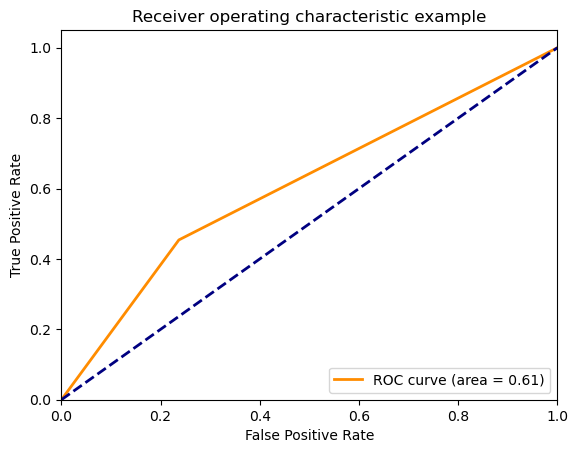

In [28]:
#Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [29]:
#Score the datasets 
probTrain = lr.predict_proba(X_train)
probTest = lr.predict_proba(X_test)

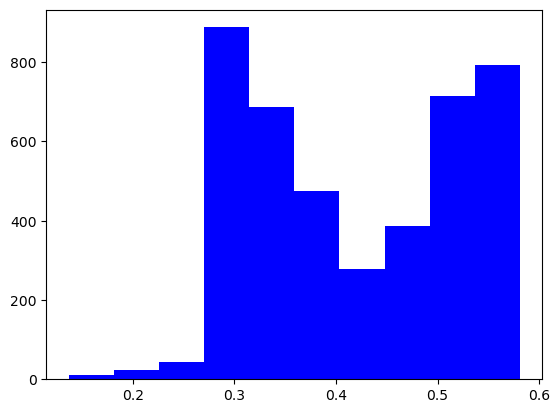

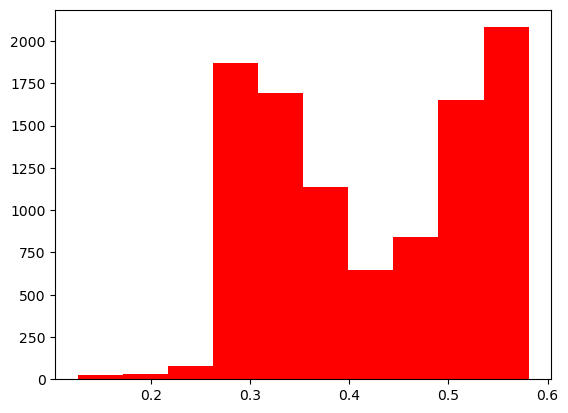

In [30]:
#check the distribution of probability values - Second column is the probabilities for the positive outcome
plt.hist(probTrain[:,1],color = 'blue')
plt.show()
plt.hist(probTest[:,1],color = 'red')
plt.show()
#The probability scores provided by the model do not exceed much close to 0.6 and the accuracy is similar
#So this is a weak predictor of shot result


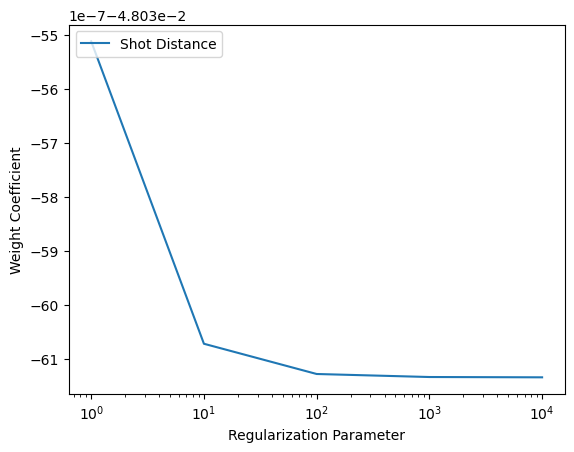

In [31]:
#Try running the algorithm several times for different values of the regularization parameter
#Logistic Regression model
weights, params, models, scores = [], [], [], []
#for c in np.arange(-5,5): - Negative values not currently allowed by the kernal but do work on my machine
for c in np.arange(0,5):
        lr = LogisticRegression(C=10**c, random_state=0)
        lr.fit(X_train, y_train)
        predTrain = lr.predict(X_train)
        accuracy = metrics.accuracy_score(y_train,predTrain)
        weights.append(lr.coef_[0])
        params.append(10**c)
        models.append(lr)
        scores.append(accuracy)
weights = np.array(weights)
plt.plot(params, weights, label='Shot Distance')
plt.xlabel('Regularization Parameter')
plt.ylabel('Weight Coefficient')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

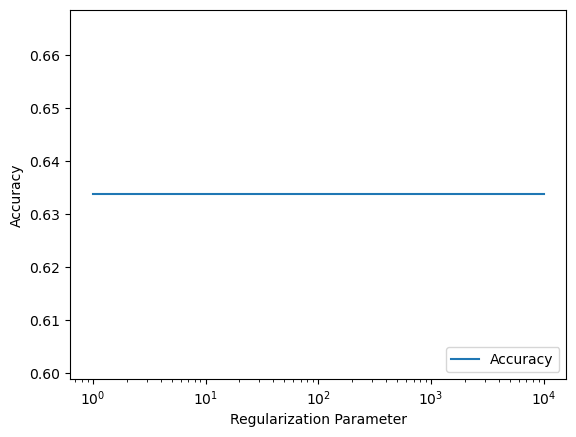

In [32]:
#Plot the accuracy of the models with the different parameter values
#Accuracy has an optimum across the range of values
plt.plot(params,scores,label='Accuracy')
plt.xlabel('Regularization Parameter')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xscale('log')
plt.show()

In [33]:
#Now look at a list of potential predictor variables
#Apply SBS (Sequential Backward Selection) to find the optimal feature list for predicting shot_result

#Define the SBS class
class SBS():
    def __init__(self, estimator, k_features, scoring=metrics.accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = base.clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
                model_selection.train_test_split(X, y, test_size=self.test_size, 
                                                 random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score


In [34]:
#Add the full list of features to the dataset
X = df[['shot_dist','close_def_dist','dribbles']]


In [35]:
#Create training and test datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.7, random_state=1)


In [36]:
#Standardize the variables
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
print(X_train.head())
print(X_train_std[0:5,])

        shot_dist  close_def_dist  dribbles
13582         8.6             2.1         2
41540        24.1             6.3         0
64785        16.6             4.7         0
114411       22.4            15.8         0
52395        12.9             2.6         1
[[-0.60735137 -0.77631238  0.04456563]
 [ 1.12526937  0.75822246 -0.51602314]
 [ 0.28690449  0.17363776 -0.51602314]
 [ 0.93524     4.22919413 -0.51602314]
 [-0.12668885 -0.59362966 -0.23572875]]


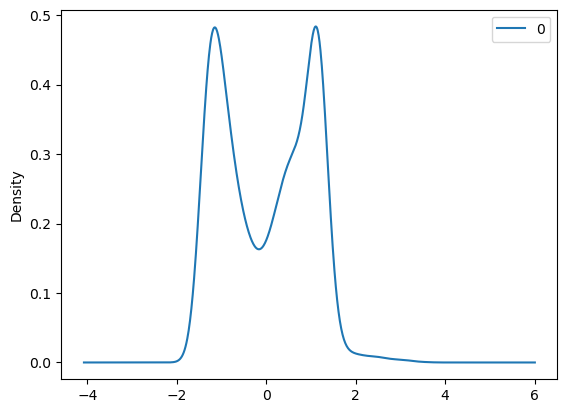

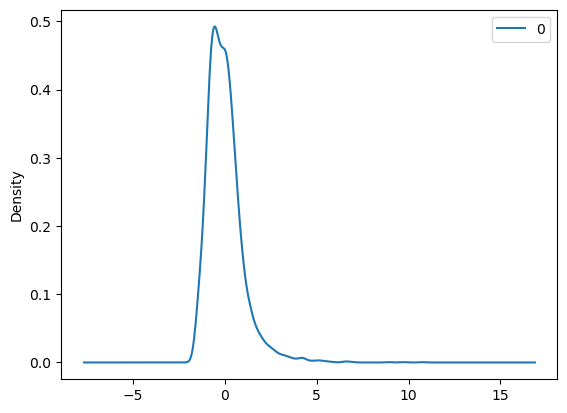

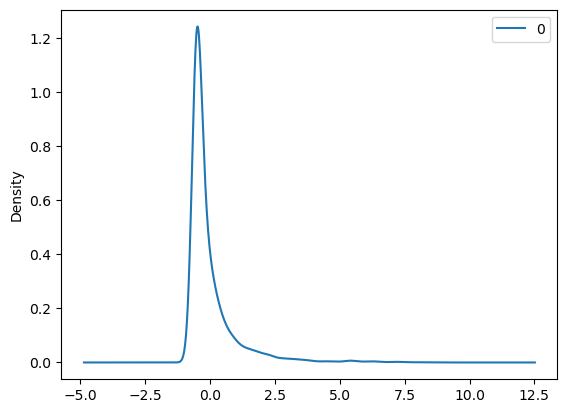

In [37]:
#Check the distributions of the standardized variables
pd.DataFrame(X_train_std[:,0]).plot(kind='kde')
plt.show()
pd.DataFrame(X_train_std[:,1]).plot(kind='kde')
plt.show()
pd.DataFrame(X_train_std[:,2]).plot(kind='kde')
plt.show()

In [38]:
#Instantiate the class
sbs = SBS(lr, k_features = 1)
sbs.fit(X_train_std, y_train)


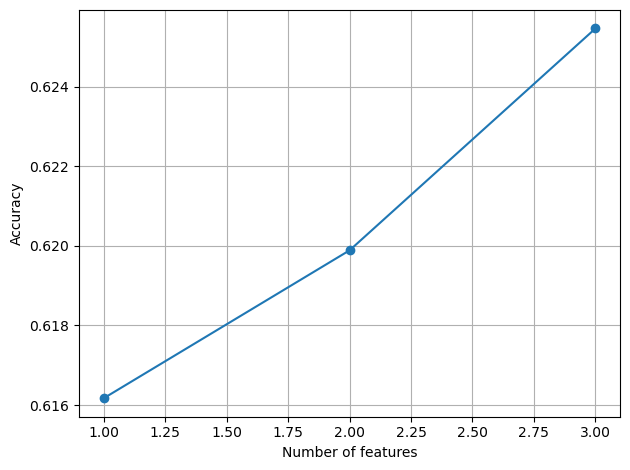

In [39]:
#plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()
#Accuracy is greatest with all 3 variables

In [40]:
#Apply dimensionality reduction via PCA (Principal Components Analysis)
#1. Standardize the full-featured dataset
#Done above
#2. Construct the covariance matrix
cov_mat = np.cov(X_train_std.T)
#3. Decompose the covariance matrix into its eigenvectors and eigenvalues
eigenvals, eigenvecs = np.linalg.eig(cov_mat)
#4. Select the top 2 eignvectors that correspond to the largest eigenvalues 
eigen_pairs = [(np.abs(eigenvals[i]),eigenvecs[:,i]) for i in range(len(eigenvals))]
eigen_pairs.sort(reverse=True)
#5. Construct a projection matrix from these top 2 eigenvectors
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
#np.newaxis transposes the vectors from horizontal to vertical
print('Matrix W: \n', w)

Matrix W: 
 [[-0.66874506  0.2740669 ]
 [-0.68819154  0.12362314]
 [ 0.281376    0.95373196]]


In [41]:
#6. Transform the input dataset using the projection matrix
X_train_pca = np.dot(X_train_std,w)
#Using the same projection matrix on the test as created with the training dataset
X_test_pca = np.dot(X_test_std,w)
lr.fit(X_train_pca, y_train)
predTrain = lr.predict(X_train_pca)
predTest = lr.predict(X_test_pca)

In [42]:
print(metrics.accuracy_score(predTrain,y_train))
print(metrics.accuracy_score(predTest,y_test))


0.6162250116225012
0.5924708694353152


In [44]:
#PCA version 2
#Using the sklearn short way

#Instantiate the PCA class
pca = PCA(n_components=2)

lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca,y_train)

predTrain = lr.predict(X_train_pca)
predTest = lr.predict(X_test_pca)

print(metrics.accuracy_score(predTrain,y_train))
print(metrics.accuracy_score(predTest,y_test))

0.6164574616457462
0.5925704611094512
